## EBOV deconvolution in Pyro

indices:
- j for cell type
- m for sample index in the sample sheet


In [1]:
import os
import pickle5
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

import torch
import pyro
from pyro.infer import SVI, Trace_ELBO

device = torch.device("cuda:0")
dtype = torch.float32
dtype_np = np.float32

## Configuration

In [2]:
# data_path = '/home/jupyter/mb-ml-data-disk/pyro-ebov-deconvolution'
data_path = "/home/nbarkas/disk1/deconvolution/data/load_data_python"

In [3]:
from typing import List, Dict
from boltons.cacheutils import cachedproperty


class EBOVDataset:
    
    def __init__(
            self,
            data_path: str,
            dtype_np: np.dtype):
        
        self.dtype_np = dtype_np
        
        # load all data
        self.bulk_raw_gex_gm = np.load(os.path.join(data_path, 'bulk_matrix.npy')).astype(dtype_np)
        
        with open(os.path.join(data_path, 'bulk_pdata.pkl'), 'rb') as f:
            loader = pickle5.Unpickler(f)
            self.bulk_sample_metadata_pd = loader.load()

        self.sc_raw_gex_gj = np.load(os.path.join(data_path, 'sc_matrix.npy'))

        with open(os.path.join(data_path, 'sc_pdata.pkl'), 'rb') as f:
            loader = pickle5.Unpickler(f)
            self.sc_sample_metadata_pd = loader.load()
            
        # shorthands
        self.num_samples = self.bulk_raw_gex_gm.shape[-1]
        self.num_genes = self.bulk_raw_gex_gm.shape[-2]
        self.num_individuals = len(set(self.bulk_sample_metadata_pd['id.individual'].values))
        
        # index individuals
        individual_str_list = sorted(list(set(self.bulk_sample_metadata_pd['id.individual'].values)))
        individual_str_to_index_map = {
            individual_str: index for index, individual_str in enumerate(individual_str_list)}
        
        # individual index of each sample
        self.m_to_i = np.asarray(list(
            map(
                individual_str_to_index_map.get,
                self.bulk_sample_metadata_pd['id.individual'].values)))
        
        # pre-process dpi times
        self.dpi_time_m = np.clip(
            self.bulk_sample_metadata_pd['dpi_time'].values.astype(dtype_np),
            a_min=0., a_max=None)
        self.dpi_time_m = self.dpi_time_m / self.dpi_time_m.max()

    @cachedproperty
    def cell_type_str_list(self) -> List[str]:
        return sorted(list(set(self.sc_sample_metadata_pd['Subclustering_reduced'])))

    @cachedproperty
    def cell_type_str_to_index_map(self) -> Dict[str, int]:
        return {cell_type_str: index for index, cell_type_str in enumerate(self.cell_type_str_list)}        

    @cachedproperty
    def num_cell_types(self) -> int:
        return len(self.cell_type_str_list)
    
    @cachedproperty
    def w_hat_gc(self) -> np.ndarray:
        w_hat_gc = np.zeros((self.num_genes, self.num_cell_types))
        for cell_type_str in self.cell_type_str_list:
            i_cell_type = self.cell_type_str_to_index_map[cell_type_str]
            mask_j = self.sc_sample_metadata_pd['Subclustering_reduced'].values == cell_type_str
            w_hat_gc[:, i_cell_type] = np.sum(self.sc_raw_gex_gj[:, mask_j], axis=-1)
            w_hat_gc[:, i_cell_type] = w_hat_gc[:, i_cell_type] / np.sum(w_hat_gc[:, i_cell_type])
        return w_hat_gc

In [4]:
ebov_dataset = EBOVDataset(data_path, dtype_np)

In [5]:
from typing import Dict

def generate_minibatch(
        dataset: EBOVDataset,
        minibatch_size: int,
        device: torch.device,
        dtype: torch.dtype,
        return_full_batch: bool = False) -> Dict[str, torch.Tensor]:
    """
    
    TODO: balanced sampling from time
    
    """
    
    # choose random samples
    if return_full_batch:
        sample_indices_n = np.arange(dataset.num_samples)
    else:
        sample_indices_n = np.random.randint(0, dataset.num_samples, size=minibatch_size)
    
    # subset data
    x_ng = dataset.bulk_raw_gex_gm[:, sample_indices_n].T
    t_n = dataset.dpi_time_m[sample_indices_n]
    ind_index_n = dataset.m_to_i[sample_indices_n]
    
    return {
        'x_ng': torch.tensor(x_ng, device=device, dtype=dtype),
        't_n': torch.tensor(t_n, device=device, dtype=dtype),
        'ind_index_n': torch.tensor(ind_index_n, device=device, dtype=torch.long),
        'sample_index_n': torch.tensor(sample_indices_n, device=device, dtype=torch.long)
    }

In [6]:
from pyro.distributions.torch_distribution import TorchDistribution, TorchDistributionMixin
from torch.distributions.utils import probs_to_logits, logits_to_probs, broadcast_all, lazy_property
from torch.distributions import constraints
from numbers import Number


class NegativeBinomialAltParam(TorchDistribution):
    r"""
    Creates a negative binomial distribution.
    
    Args:
        mu (Number, Tensor): mean (must be strictly positive)
        phi (Number, Tensor): overdispersion (must be strictly positive)
    """
    arg_constraints = {'mu': constraints.positive, 'phi': constraints.positive}
    support = constraints.nonnegative_integer
    EPS = 1e-6
    
    def __init__(self, mu, phi, validate_args=None):
        self.mu, self.phi = broadcast_all(mu, phi)
        if all(isinstance(_var, Number) for _var in (mu, phi)): 
            batch_shape = torch.Size()
        else:
            batch_shape = self.mu.size()
        super(NegativeBinomialAltParam, self).__init__(batch_shape, validate_args=validate_args)
        
    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(NegativeBinomialAltParam, _instance)
        batch_shape = torch.Size(batch_shape)
        new.mu = self.mu.expand(batch_shape)
        new.phi = self.phi.expand(batch_shape)
        
        super(NegativeBinomialAltParam, new).__init__(batch_shape, validate_args=False)
        new._validate_args = self._validate_args
        return new
    
    @lazy_property
    def _gamma(self):
        return torch.distributions.Gamma(
            concentration=self.phi.reciprocal(),
            rate=(self.mu * self.phi).reciprocal())

    def sample(self, sample_shape=torch.Size()):
        with torch.no_grad():
            return torch.poisson(self._gamma.sample(sample_shape=sample_shape))
        
    @property
    def mean(self):
        return self.mu
    
    @property
    def variance(self):
        return self.mu + self.phi * self.mu.pow(2)
    
    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
        mu, phi, value = broadcast_all(self.mu, self.phi, value)
        alpha = (self.EPS + phi).reciprocal()
        return ((value + alpha).lgamma() - (value + 1).lgamma() - alpha.lgamma()
                + alpha * (alpha.log() - (alpha + mu).log())
                + value * (mu.log() - (alpha + mu).log()))

In [7]:
import pyro.distributions as dist


class PseudoTimeRegDeconvolution:
    """
    
    .. note: we use "n" for batch dimension, and "m" for sample index.
    
    """
    
    def  __init__(
            self,
            dataset: EBOVDataset,
            device: device,
            dtype: dtype):
        
        self.dataset = dataset
        self.device = device
        self.dtype = dtype
        
        # hyperparameters
        self.log_beta_prior_scale = 1.0
        self.log_r_prior_scale = 1.0
        self.tau_prior_scale = 1.0
        self.log_phi_prior_loc = -5.0
        self.log_phi_prior_scale = 1.0
        
        self.unnorm_cell_pop_base_prior_loc_c = np.zeros((self.dataset.num_cell_types,))
        self.unnorm_cell_pop_base_prior_scale_c = np.ones((self.dataset.num_cell_types,))
        
        # first order population deformation
        self.unnorm_cell_pop_deform_prior_loc_c = np.zeros((self.dataset.num_cell_types,))
        self.unnorm_cell_pop_deform_prior_scale_c = np.ones((self.dataset.num_cell_types,))
        
        # second order population deformation
        self.unnorm_cell_pop_deform2_prior_loc_c = np.zeros((self.dataset.num_cell_types,))
        self.unnorm_cell_pop_deform2_prior_scale_c = np.ones((self.dataset.num_cell_types,))        
        
        self.unnorm_cell_pop_deform3_prior_loc_c = np.zeros((self.dataset.num_cell_types,))
        self.unnorm_cell_pop_deform3_prior_scale_c = np.ones((self.dataset.num_cell_types,)) 

        self.init_posterior_global_scale_factor = 0.05
        
        self.log_beta_posterior_scale = 1.0 * self.init_posterior_global_scale_factor
        self.log_r_posterior_scale = 1.0 * self.init_posterior_global_scale_factor
        self.tau_posterior_scale = 1.0 * self.init_posterior_global_scale_factor
        self.log_phi_posterior_loc = -5.0
        self.log_phi_posterior_scale = 0.1 * self.init_posterior_global_scale_factor
        
        self.unnorm_cell_pop_base_posterior_loc_c = np.zeros((self.dataset.num_cell_types,))
        self.unnorm_cell_pop_base_posterior_scale_c = self.init_posterior_global_scale_factor * np.ones((self.dataset.num_cell_types,))
        
        self.unnorm_cell_pop_deform_posterior_loc_c = np.zeros((self.dataset.num_cell_types,))
        self.unnorm_cell_pop_deform_posterior_scale_c = self.init_posterior_global_scale_factor * np.ones((self.dataset.num_cell_types,))
        
        self.unnorm_cell_pop_deform2_posterior_loc_c = np.zeros((self.dataset.num_cell_types,))
        self.unnorm_cell_pop_deform2_posterior_scale_c = self.init_posterior_global_scale_factor * np.ones((self.dataset.num_cell_types,))
        
        # cache useful tensors
        self.w_hat_gc = torch.tensor(self.dataset.w_hat_gc, device=device, dtype=dtype)
        
    def model(
            self,
            x_ng: torch.Tensor,
            t_n: torch.Tensor,
            ind_index_n: torch.Tensor,
            sample_index_n: torch.Tensor):
        """
        :param x_ng: gene expression
        :param t_n: obseration time
        :param ind_index_n: index of the individual
        :param sample_index_n: index of the sample in the dataset
        """
        
        minibatch_size = x_ng.shape[0]
        
        # sample log_phi_g
        log_phi_g = pyro.sample(
            'log_phi_g',
            dist.Normal(
                loc=self.log_phi_prior_loc * torch.ones(
                    (self.dataset.num_genes,), device=self.device, dtype=self.dtype),
                scale=self.log_phi_prior_scale * torch.ones(
                    (self.dataset.num_genes,), device=self.device, dtype=self.dtype)).to_event(1))
        
        # sample log_beta_g
        log_beta_g = pyro.sample(
            'log_beta_g',
            dist.Normal(
                loc=torch.zeros(
                    (self.dataset.num_genes,), device=self.device, dtype=self.dtype),
                scale=self.log_beta_prior_scale * torch.ones(
                    (self.dataset.num_genes,), device=self.device, dtype=self.dtype)).to_event(1))
        
        # sample log_r_i
        log_r_i = pyro.sample(
            'log_r_i',
            dist.Normal(
                loc=torch.zeros(
                    (self.dataset.num_individuals,), device=self.device, dtype=self.dtype),
                scale=self.log_r_prior_scale * torch.ones(
                    (self.dataset.num_individuals,), device=self.device, dtype=self.dtype)).to_event(1))
        
        # sample unnorm_cell_pop_base_c
        unnorm_cell_pop_base_c = pyro.sample(
            'unnorm_cell_pop_base_c',
            dist.Normal(
                loc=torch.tensor(
                    self.unnorm_cell_pop_base_prior_loc_c,
                    device=self.device, dtype=self.dtype),
                scale=torch.tensor(
                    self.unnorm_cell_pop_base_prior_scale_c,
                    device=self.device, dtype=self.dtype)).to_event(1))
        
        # sample unnorm_cell_pop_base_c
        unnorm_cell_pop_deform_c = pyro.sample(
            'unnorm_cell_pop_deform_c',
            dist.Normal(
                loc=torch.tensor(
                    self.unnorm_cell_pop_deform_prior_loc_c,
                    device=self.device, dtype=self.dtype),
                scale=torch.tensor(
                    self.unnorm_cell_pop_deform_prior_scale_c,
                    device=self.device, dtype=self.dtype)).to_event(1))
        
        # sample unnorm_cell_pop_base_c
        unnorm_cell_pop_deform2_c = pyro.sample(
            'unnorm_cell_pop_deform2_c',
            dist.Normal(
                loc=torch.tensor(
                    self.unnorm_cell_pop_deform2_prior_loc_c,
                    device=self.device, dtype=self.dtype),
                scale=torch.tensor(
                    self.unnorm_cell_pop_deform2_prior_scale_c,
                    device=self.device, dtype=self.dtype)).to_event(1))
        
        # calculate useful derived variables
        beta_g = log_beta_g.exp()
        phi_g = log_phi_g.exp()
        
#         ### NOTE ###
#         phi_g = 0.01 * torch.ones((self.dataset.num_genes,), device=self.device, dtype=self.dtype)
#         beta_g = torch.ones((self.dataset.num_genes,), device=self.device, dtype=self.dtype)
        
        unnorm_w_gc = self.w_hat_gc * beta_g[:, None]
        w_gc = unnorm_w_gc / unnorm_w_gc.sum(0)
        r_n = log_r_i[ind_index_n].exp()
        
        with pyro.poutine.scale(scale=self.dataset.num_samples / minibatch_size):
            
            with pyro.plate("batch"):

                # sample tau ("actual infection") for each sample
                tau_mean_shift_n = t_n / r_n
                tau_deviation_n = pyro.sample(
                    "tau_deviation_n",
                    dist.Normal(
                        loc=torch.zeros_like(t_n),
                        scale=self.tau_prior_scale * torch.ones_like(t_n)))
                tau_n = tau_mean_shift_n + tau_deviation_n

                # calculate cell proportion
                cell_pop_nc = torch.nn.functional.softmax(
                    unnorm_cell_pop_base_c + unnorm_cell_pop_deform_c * tau_n[:, None] + 
                        unnorm_cell_pop_deform2_c * (tau_n[:,None] * tau_n[:,None]),
                    dim=-1)

                # calculate mean gene expression
                mu_ng = x_ng.sum(-1)[:, None] * torch.matmul(cell_pop_nc, w_gc.transpose(-1, -2))

                # observe gene expression
                pyro.sample(
                    "x_ng",
                    NegativeBinomialAltParam(
                        mu=mu_ng,
                        phi=phi_g[None, :]).to_event(1),
                    obs=x_ng)

    def delta_guide(
            self,
            x_ng: torch.Tensor,
            t_n: torch.Tensor,
            ind_index_n: torch.Tensor,
            sample_index_n: torch.Tensor):
        
        minibatch_size = x_ng.shape[0]
        
        # variational parameters for log_phi_g
        log_phi_posterior_loc_g = pyro.param(
            "log_phi_posterior_loc_g",
            self.log_phi_posterior_loc * torch.ones(
                (self.dataset.num_genes,), device=self.device, dtype=self.dtype))

        # variational parameters for log_beta_g
        log_beta_posterior_loc_g = pyro.param(
            "log_beta_posterior_loc_g",
            torch.zeros(
                (self.dataset.num_genes,), device=self.device, dtype=self.dtype))        
        
        # variational parameters for log_r_i
        log_r_posterior_loc_i = pyro.param(
            "log_r_posterior_loc_i",
            torch.zeros(
                (self.dataset.num_individuals,), device=self.device, dtype=self.dtype))
        
        # variational parameters for unnorm_cell_pop_base_c ("B_c")
        unnorm_cell_pop_base_posterior_loc_c = pyro.param(
            "unnorm_cell_pop_base_posterior_loc_c",
            torch.tensor(
                self.unnorm_cell_pop_base_posterior_loc_c,
                device=self.device, dtype=self.dtype))
        
        # variational parameters for unnorm_cell_pop_deform_c ("R_c")
        unnorm_cell_pop_deform_posterior_loc_c = pyro.param(
            "unnorm_cell_pop_deform_posterior_loc_c",
            torch.tensor(
                self.unnorm_cell_pop_deform_posterior_loc_c,
                device=self.device, dtype=self.dtype))
        
        # variational parameters for unnorm_cell_pop_deform_c ("R_c")
        unnorm_cell_pop_deform2_posterior_loc_c = pyro.param(
            "unnorm_cell_pop_deform2_posterior_loc_c",
            torch.tensor(
                self.unnorm_cell_pop_deform2_posterior_loc_c,
                device=self.device, dtype=self.dtype))
        
        # variational parameters for tau_deviation_m
        tau_deviation_posterior_loc_m = pyro.param(
            "tau_deviation_posterior_loc_m",
            torch.zeros(
                (self.dataset.num_samples,),
                device=self.device, dtype=self.dtype))
        
        # posterior sample statements
        log_phi_g = pyro.sample(
            "log_phi_g",
            dist.Delta(
                v=log_phi_posterior_loc_g).to_event(1))

        log_beta_g = pyro.sample(
            "log_beta_g",
            dist.Delta(
                v=log_beta_posterior_loc_g).to_event(1))

        log_r_i = pyro.sample(
            "log_r_i",
            dist.Delta(
                v=log_r_posterior_loc_i).to_event(1))

        unnorm_cell_pop_base_c = pyro.sample(
            'unnorm_cell_pop_base_c',
            dist.Delta(
                v=unnorm_cell_pop_base_posterior_loc_c).to_event(1))
        
        unnorm_cell_pop_deform_c = pyro.sample(
            'unnorm_cell_pop_deform_c',
            dist.Delta(
                v=unnorm_cell_pop_deform_posterior_loc_c).to_event(1))
        
        unnorm_cell_pop_deform2_c = pyro.sample(
            'unnorm_cell_pop_deform2_c',
            dist.Delta(
                v=unnorm_cell_pop_deform2_posterior_loc_c).to_event(1))
        
        with pyro.poutine.scale(scale=self.dataset.num_samples / minibatch_size):

            with pyro.plate("batch"):
            
                tau_deviation_n = pyro.sample(
                    "tau_deviation_n",
                    dist.Delta(
                        v=tau_deviation_posterior_loc_m[sample_index_n]))
    

In [8]:
pseudo_time_reg_deconv = PseudoTimeRegDeconvolution(
    dataset=ebov_dataset,
    device=device,
    dtype=dtype)

pyro.clear_param_store()

In [9]:
# minibatch_dict = generate_minibatch(ebov_dataset, 10, device, dtype)

# pseudo_time_reg_deconv.model(
#     x_ng=minibatch_dict['x_ng'],
#     t_n=minibatch_dict['t_n'],
#     ind_index_n=minibatch_dict['ind_index_n'],
#     sample_index_n=minibatch_dict['sample_indices_n'])

# pseudo_time_reg_deconv.guide(
#     x_ng=minibatch_dict['x_ng'],
#     t_n=minibatch_dict['t_n'],
#     ind_index_n=minibatch_dict['ind_index_n'],
#     sample_index_n=minibatch_dict['sample_indices_n'])

In [10]:
n_iters = 10_000
minibatch_size = 50
log_frequency = 100

In [11]:
# optimizer
optim = pyro.optim.Adam(
    {'lr': 5e-3})

loss_hist = []

In [12]:
# SVI objective
svi = SVI(
    model=pseudo_time_reg_deconv.model,
    guide=pseudo_time_reg_deconv.delta_guide,
    optim=optim,
    loss=Trace_ELBO())

In [13]:
for i_iter in range(n_iters):
    
    minibatch_dict = generate_minibatch(
        ebov_dataset, minibatch_size, device, dtype,
        return_full_batch=True)
    loss = svi.step(**minibatch_dict)
    
    loss_hist.append(loss)
    
    if i_iter % log_frequency == 0:
        print(f"{i_iter}   loss: {loss_hist[-1]}")

0   loss: 94785425.99514198
100   loss: 44332221.97444248
200   loss: 25780063.217264175
300   loss: 16957764.067871094
400   loss: 12290146.240962029
500   loss: 9707986.904691696
600   loss: 8205907.402504921
700   loss: 7277682.936987877
800   loss: 6668553.321181297
900   loss: 6247599.203063965
1000   loss: 5944209.548402786
1100   loss: 5718079.209718704
1200   loss: 5544862.165060997
1300   loss: 5409163.606514931
1400   loss: 5300844.923013687
1500   loss: 5212985.502362251
1600   loss: 5140729.9661951065
1700   loss: 5080588.004858971
1800   loss: 5030002.256583214
1900   loss: 4987063.194574356
2000   loss: 4950310.363239288
2100   loss: 4918615.835582733
2200   loss: 4891102.39081955
2300   loss: 4867072.3216257095
2400   loss: 4845973.486498833
2500   loss: 4827355.851456642
2600   loss: 4810855.39968586
2700   loss: 4796172.628001213
2800   loss: 4783050.929405212
2900   loss: 4771285.817840576
3000   loss: 4760706.330900192
3100   loss: 4751166.340168953
3200   loss: 4742

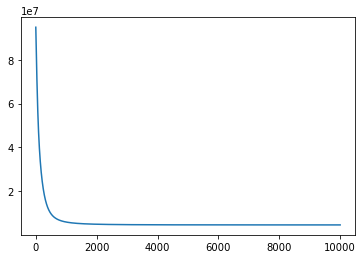

In [14]:
plt.plot(loss_hist)

In [15]:
pyro.get_param_store().keys()

dict_keys(['log_phi_posterior_loc_g', 'log_beta_posterior_loc_g', 'log_r_posterior_loc_i', 'unnorm_cell_pop_base_posterior_loc_c', 'unnorm_cell_pop_deform_posterior_loc_c', 'unnorm_cell_pop_deform2_posterior_loc_c', 'tau_deviation_posterior_loc_m'])

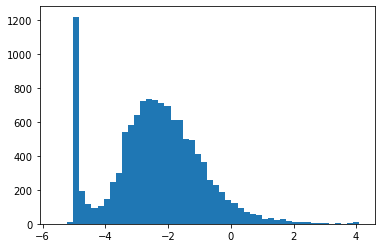

In [16]:
# Histogram of the posterior estimates of the gene dispersion (phi)
plt.hist(pyro.param('log_phi_posterior_loc_g').detach().cpu().numpy(), bins=50);

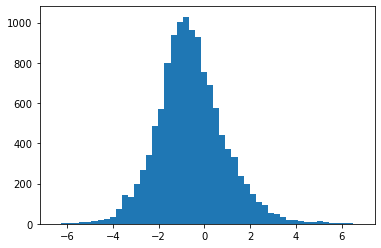

In [17]:
# Histogram of the posterior estimates of the gene betas (scaling coefficients of genes)
plt.hist(pyro.param('log_beta_posterior_loc_g').detach().cpu().numpy(), bins=50);

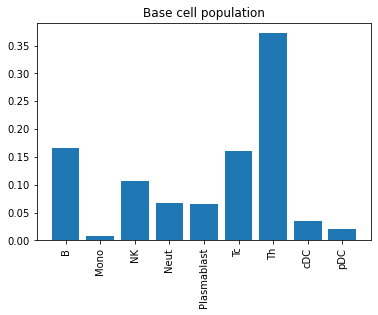

In [18]:
# Plot the celltype base composition

fig = plt.figure()
ax = plt.gca()

ax.bar(
    np.arange(ebov_dataset.num_cell_types),
    torch.nn.functional.softmax(pyro.param("unnorm_cell_pop_base_posterior_loc_c"), dim=0).detach().cpu().numpy())

ax.set_title('Base cell population')
ax.set_xticks(np.arange(ebov_dataset.num_cell_types))
ax.set_xticklabels(ebov_dataset.cell_type_str_list, rotation=90);

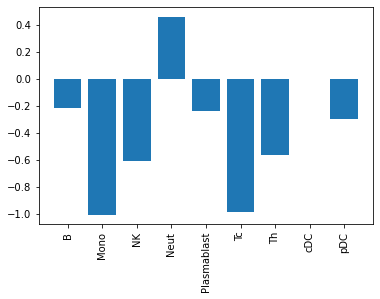

In [19]:
# Plot the deltas of the celltype composition

fig = plt.figure()
ax = plt.gca()

ax.bar(
    np.arange(ebov_dataset.num_cell_types),
    pyro.param("unnorm_cell_pop_deform_posterior_loc_c").detach().cpu().numpy())

ax.set_xticks(np.arange(ebov_dataset.num_cell_types))
ax.set_xticklabels(ebov_dataset.cell_type_str_list, rotation=90);

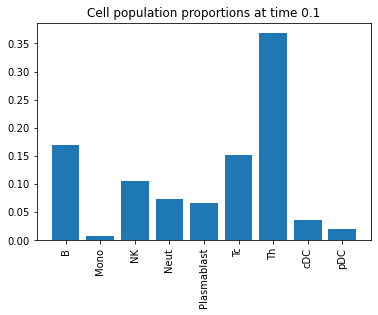

In [20]:
# celltype composition at time 0.1
time = 0.1

base_composition_post = pyro.param("unnorm_cell_pop_base_posterior_loc_c").detach().cpu()
delta_composition_post = pyro.param("unnorm_cell_pop_deform_posterior_loc_c").detach().cpu()
delta2_composition_post = pyro.param("unnorm_cell_pop_deform2_posterior_loc_c").detach().cpu()
    
norm_comp_t = torch.nn.functional.softmax(base_composition_post + 
                                          time * delta_composition_post + 
                                          time**2 * delta2_composition_post , dim=0).numpy()

fig = plt.figure()
ax = plt.gca()

ax.bar(
    np.arange(ebov_dataset.num_cell_types),
    norm_comp_t
)

ax.set_title(f'Cell population proportions at time {time}')
ax.set_xticks(np.arange(ebov_dataset.num_cell_types))
ax.set_xticklabels(ebov_dataset.cell_type_str_list, rotation=90);

In [21]:
times = torch.arange(0,1,0.1)
times.unsqueeze(1).shape

torch.Size([10, 1])

In [22]:
delta_composition_post
delta_composition_post.shape

torch.Size([9])

In [23]:
times*times

tensor([0.0000, 0.0100, 0.0400, 0.0900, 0.1600, 0.2500, 0.3600, 0.4900, 0.6400,
        0.8100])

In [24]:
composition_deltas = times.unsqueeze(1) @ delta_composition_post.unsqueeze(0) + \
    (times * times).unsqueeze(1) @ delta2_composition_post.unsqueeze(0)

In [25]:
composition_over_time = torch.nn.functional.softmax(base_composition_post.expand(10,9) + composition_deltas, dim=1)

In [26]:
composition_over_time

tensor([[0.1656, 0.0081, 0.1066, 0.0664, 0.0657, 0.1599, 0.3719, 0.0353, 0.0204],
        [0.1690, 0.0076, 0.1050, 0.0737, 0.0671, 0.1520, 0.3678, 0.0370, 0.0208],
        [0.1709, 0.0070, 0.1031, 0.0836, 0.0680, 0.1449, 0.3624, 0.0390, 0.0212],
        [0.1709, 0.0063, 0.1008, 0.0970, 0.0685, 0.1385, 0.3553, 0.0411, 0.0216],
        [0.1689, 0.0056, 0.0980, 0.1149, 0.0685, 0.1324, 0.3464, 0.0433, 0.0221],
        [0.1647, 0.0048, 0.0946, 0.1387, 0.0677, 0.1264, 0.3350, 0.0456, 0.0225],
        [0.1579, 0.0041, 0.0904, 0.1700, 0.0661, 0.1202, 0.3206, 0.0478, 0.0228],
        [0.1484, 0.0033, 0.0853, 0.2110, 0.0635, 0.1135, 0.3024, 0.0497, 0.0228],
        [0.1359, 0.0026, 0.0789, 0.2637, 0.0597, 0.1057, 0.2798, 0.0511, 0.0226],
        [0.1205, 0.0020, 0.0711, 0.3296, 0.0546, 0.0966, 0.2521, 0.0514, 0.0219]])

In [27]:
composition_over_time[:,0]

tensor([0.1656, 0.1690, 0.1709, 0.1709, 0.1689, 0.1647, 0.1579, 0.1484, 0.1359,
        0.1205])

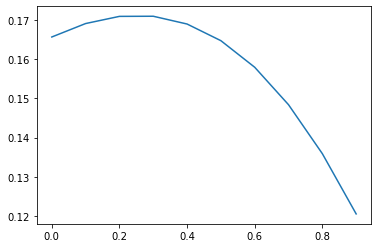

In [28]:
fig = plt.figure()
ax = plt.gca()

ax.plot(times.numpy(), composition_over_time[:,0])

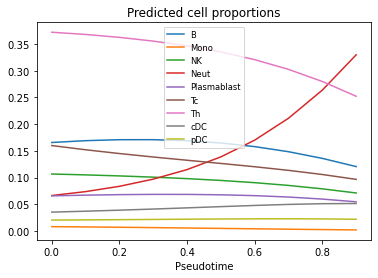

In [29]:
fig = plt.figure()
ax = plt.gca()

ax.plot(times.numpy(), composition_over_time)

ax.set_title("Predicted cell proportions")
ax.set_xlabel("Pseudotime")
ax.legend(ebov_dataset.cell_type_str_list,loc='best',fontsize='small')

In [30]:
pyro.get_param_store().keys()

dict_keys(['log_phi_posterior_loc_g', 'log_beta_posterior_loc_g', 'log_r_posterior_loc_i', 'unnorm_cell_pop_base_posterior_loc_c', 'unnorm_cell_pop_deform_posterior_loc_c', 'unnorm_cell_pop_deform2_posterior_loc_c', 'tau_deviation_posterior_loc_m'])

In [31]:
# These are the per individual infection rates
pyro.param('log_r_posterior_loc_i').exp()

tensor([0.4985, 0.5967, 0.6300, 0.5396, 1.0340, 0.5015, 0.5577, 0.7113, 0.6502,
        1.0000, 0.6472, 1.0712, 0.5657, 0.9131, 0.9724, 0.6400, 0.9262, 1.0000,
        0.5616, 0.5310, 1.0000], device='cuda:0', grad_fn=<ExpBackward>)

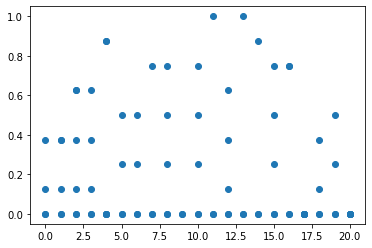

In [32]:
plt.scatter(
    ebov_dataset.m_to_i,
    ebov_dataset.dpi_time_m)